# Neural Network Models, Regularization, and Cross Validation

In this notebook we will look at neural network models for both regression and classification, and how to use cross-validation to choose regularization parameters and other aspects of neural network design.

## Classification using Neural Networks

As with other machine learning models, we begin by loading a data set. For our classification problem, we will use an expanded version of the readmission data from one of the lessons from Week 1. We read the external file into a `DataFrame`, loading the readmission data from one of the lessons from Week 1. 

In [10]:
#load and view data
import io
import pandas as pd
readmission_data = pd.read_csv('nn_readmission_multivariate.csv')
readmission_data.head()

,Length of Stay,Age,Gender (Female=1),No. of Medical Conditions,Readmission
0,0,25,0,3,0
1,1,67,1,5,0
2,2,89,0,1,0
3,4,19,0,1,0
4,8,78,0,4,1


 We will first divide the dataset into training and testing data. `scikit-learn` provides a helpful function for this called `train_test_split`. We divide our data into features and outcomes as usual, then pass this data to the function. We also specify what proportion of our data will be in the testing set – setting the `test_size` parameter to 0.2 holds out 20% of the data for testing, chosen randomly. Setting `random_state` to an integer ensures that each time we run this code, the data is split in the same way.

In [11]:
#create training and testing data
from sklearn.model_selection import train_test_split
X = readmission_data[['Length of Stay', 'Age', 'Gender (Female=1)',
       'No. of Medical Conditions']]
y = readmission_data.Readmission
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

The structure of the training code for neural networks is very similar to the scikit-learn code used for linear and logistic regression, simply using the class `MLPClassifier` instead. Once again, we set `random_state` to an integer value - since neural network training involves stochastic elements, setting this value is necessary to ensure that we get the same results each time we run the code. 

The structure of the network is governed by the parameter `hidden_layer_sizes`, which takes a set of number of neurons for each layer of the neural network. For instance, `(3, )` would be a neural network with one layer of three neurons. `(3, 2)` would be a neural network with a 3-neuron layer, fed into a subsequent 2-neuron layer. 

The `activation` parameter controls the activation function. By default, it is set to `'relu'` - the ReLU activation function. `'logistic'` is the sigmoid activation function. 

The `alpha` parameter is the quadratic regularization term (equivalent to $\lambda$ in the earlier lessons). 

The `max_iter` parameter controls how long the optimization algorithm for minimizing the error function will run. Increasing this may improve the accuracy of the neural network model, at the expense of longer run-times.

In [12]:
#set random seed
import numpy as np
np.random.seed(0)

#train neural network
from sklearn.neural_network import MLPClassifier

NN_model_classify = MLPClassifier( alpha=0.0,
                     hidden_layer_sizes=(3, ), activation='logistic', max_iter=500, random_state = 0)

NN_model_classify.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=0.0, hidden_layer_sizes=(3,),
              max_iter=500, random_state=0)

You may see a convergence warning given by `scikit-learn` above. This means that the minimization of the error function has not reached its predeteremined stopping criteria - you can optimize further by increasing `max_iter`, but for now we will use the model as is. 

Below, we plot a confusion matrix, as we did in the logistic regression excercise. However, this time, we use the held out testing data, which our model has not seen yet, to more accurately judge its performance.

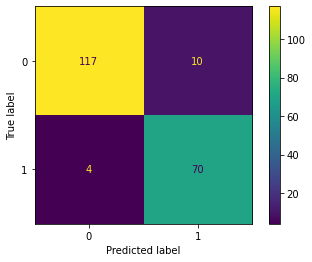

In [13]:
#visualize predictions vs. true values for test set
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(NN_model_classify, X_test, y_test)
plt.show()

`scikit-learn` has a convenient function for cross validation `cross_val_score`. It divides the data set into `cv` portions, repeats the validation procedure using each portion as a validation set and the rest of the data to train the model. This creates `cv` different scores, that can be used to evaluate the model parameters. By default, the scores are 1 minus the misclassification rate discussed in an earlier lesson from this week.  

The code below trains a model for three different values of the regularization parameter `alpha` using cross-validation evaluation approach. Note that with `cv = 4`, the validation portion of the set is 20% of the size of our original dataset.

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np

#define cross validatation function (and ignore convergence warnings)
@ignore_warnings(category=ConvergenceWarning)
def cross_validate_alpha(alphas,X_train,y_train):
  #for each alpha being tested, perform cross validation
  for alpha in alphas:    
    NN_model_classify = MLPClassifier( alpha=alpha,
                        hidden_layer_sizes=(3, ), activation='logistic', max_iter=500, random_state=0)
    #apply cross validation to compute 4 scores (one for each held out portion of the training set)
    score = cross_val_score(NN_model_classify, X_train, y_train, cv=4)
    #report average score
    print("With alpha = %s, average cross validation score of %s" % (alpha, np.mean(score)))

cross_validate_alpha([0.0,0.1, 1.0,5.0,10.0],X_train,y_train)

With alpha = 0.0, average cross validation score of 0.9299999999999999
With alpha = 0.1, average cross validation score of 0.9299999999999999
With alpha = 1.0, average cross validation score of 0.9312499999999999
With alpha = 5.0, average cross validation score of 0.9175000000000001
With alpha = 10.0, average cross validation score of 0.885


Looking at the cross validation scores, we see that an `alpha` of 1.0 provides the highest cross-validation score. This suggests we may wish to use this value to train the model and report testing performance.

## Regression using Neural Networks

We now will apply neural networks to a regression problem where we predict continuous values. We will return to an expanded version of market size dataset from last week's lessons.

In [6]:
#load and view data
import io
import pandas as pd
marketsize_data = pd.read_csv('nn_marketsize_multivariate.csv')
marketsize_data.head()

,Distance,OriginPop,DestinationPop,MarketSize
0,1070.9,7.2,7.1,6.4
1,984.7,7.0,7.9,8.1
2,2041.4,11.7,11.5,8.1
3,1677.8,11.6,11.9,5.7
4,1160.7,10.0,8.9,10.6


Once again, we will split the data into training and testing data, with market size as our prediction target.

In [7]:
#create training and testing data
from sklearn.model_selection import train_test_split
X = marketsize_data[['Distance', 'OriginPop', 'DestinationPop',]]
y = marketsize_data.MarketSize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We can now train our neural network, this time using `MLPRegressor` instead of `MLPClassifier`. The function parameters of interest are largely similar - this time we will train a network with three neurons in the first layer and two in the second layer, and use a ReLU activation function.

In [8]:
#train neural network
from sklearn.neural_network import MLPRegressor

NN_model_regress = MLPRegressor( alpha=0.0001,
                     hidden_layer_sizes=(3, 2), activation='relu',max_iter=500, random_state=0)

NN_model_regress.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(3, 2), max_iter=500, random_state=0)

Next, we look at our model performance using mean absolute error and mean squared error, this time on the testing set instead of the training set.

In [9]:
#examine testing error
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, NN_model_regress.predict(X_test)))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, NN_model_regress.predict(X_test)))

Mean Absolute Error: 7.708491876003192
Mean Squared Error: 71.06722455342761
